In [53]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2 as cv
from dataset import CustomImageDataset
from torch.utils.data import DataLoader
from skimage import exposure
from skimage.exposure import match_histograms
import ImageProcessing as IP
import torchvision.transforms as transforms

Declaring image directories

In [77]:
RGB_dir ='./Sample RGB/'
Depth_dir = './Sample Depth/'
ref_dir = './Manhatta Frames/'

Creating custom dataset

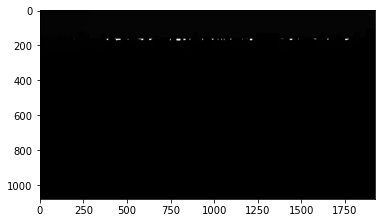

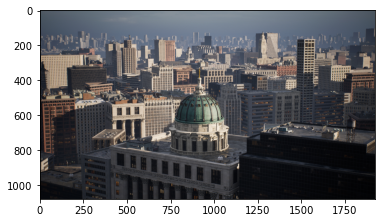

In [87]:
data = CustomImageDataset(img_dir= RGB_dir, depth_dir= Depth_dir)
data_loader = DataLoader(data, batch_size=10, shuffle=True) #Loads a random RGB, Depth couple from the dataset
rgb_img, depth_img = next(iter(data_loader)) #Unsqueezes and converts to tensor, may need to squeeze(0)
plt.imshow(depth_img[0], cmap='gray')
plt.show()
plt.imshow(rgb_img[0])
plt.show()

Transforming RGB images

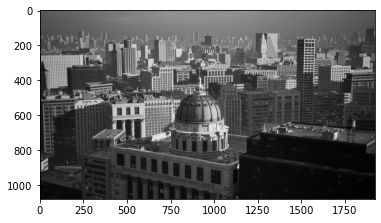

In [89]:
test_img = IP.rgb_transform(rgb_img[0])
plt.imshow(test_img.transpose(0,2).transpose(0,1), cmap='gray')

Matching histogram

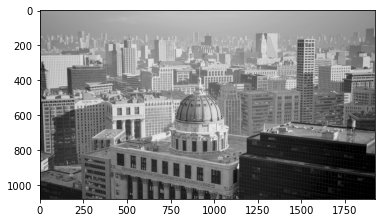

In [90]:
import importlib
importlib.reload(IP)

matched_img = IP.histogram_matching(test_img, ref_dir)
plt.imshow(matched_img.transpose(1,2,0), cmap='gray')

Processing a scene for consistent depth prediction

In [112]:
for i,img in enumerate(rgb_img):
    img = IP.rgb_transform(img)
    matched_img = IP.histogram_matching(img, ref_dir)
    cv.imwrite('./consistent_depth-main/color_full/' + str(i) + '.jpeg' , matched_img.transpose(1,2,0))


True
True
True
True
True
True
True
True
True
True
